In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import cv2

print("hello world")

hello world


# Project Overview


<img src="images/pld3280-fig-0001-m.jpg" width="800" height="600">

## Part 1. Thresholding the image strips

Load the custom strips into the notebook and threshold them to get the binary images.

In [2]:
import os
import glob

# get a list of all images in data/new_strips
images = glob.glob("data/new_strips/*.png")

print(f"We have {len(images)} images to play with")

We have 9 images to play with


In [3]:
def load_gray_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = numpy.clip(equalized, clip_low, clip_high)
    return equalized

## Display our custom strips

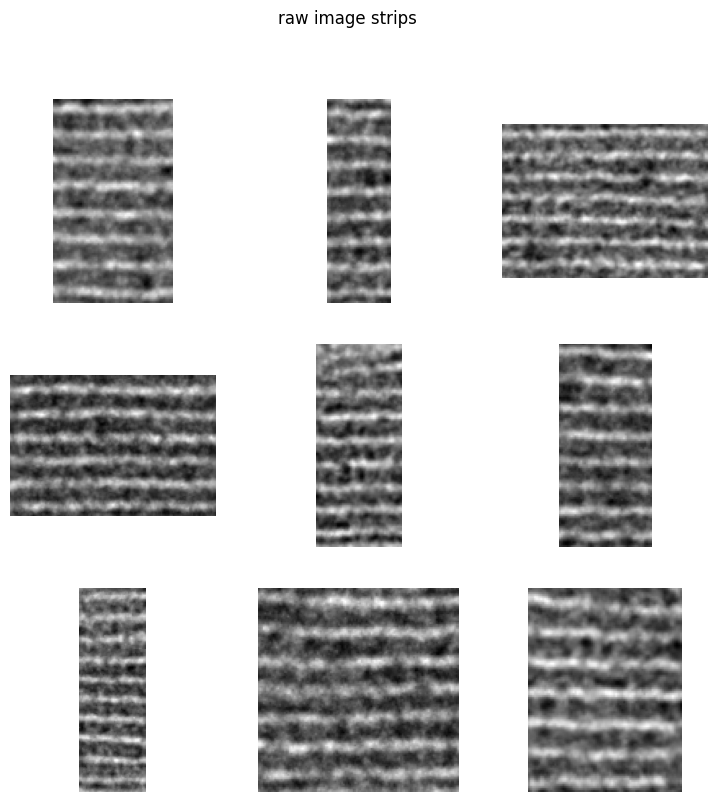

In [4]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("raw image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Display all of the strips, with balanced and clipped scale


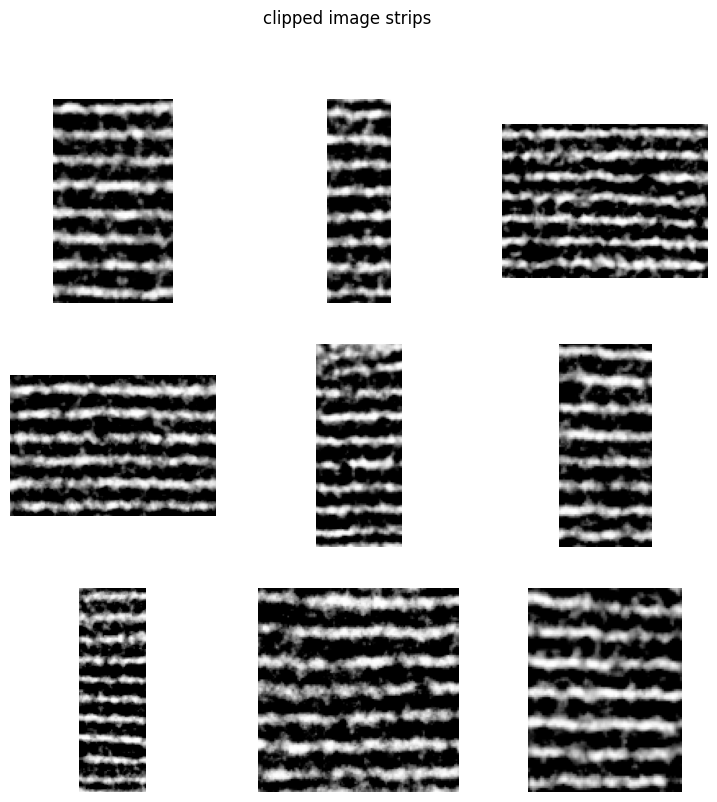

In [5]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("clipped image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    image = equalize_image(image, clip_low=100, clip_high=255)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Threshold the image using the Otsu method

The Otus method is a simple and effective way to threshold an image. It calculates the threshold value based on the histogram of the image. The threshold value is the value that minimizes the intra-class variance of the two classes.

Text(0.5, 1.0, 'Otsu Thresholded Image')

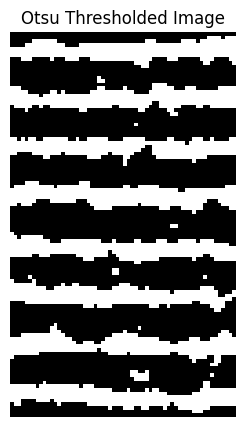

In [6]:
# threshold the image using a smart thresholding technique

clip_low, clip_high = 100, 255

def threshold_image(image, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2):
    _, thresholded = cv2.threshold(image, 0, 255, threshold_type + cv2.THRESH_OTSU)
    return thresholded

image = load_gray_image(images[0])
equalized = equalize_image(image, clip_low=clip_low, clip_high=clip_high)
thresholded = threshold_image(equalized)

# plot the thresholded image
plt.figure(figsize=(5, 5))
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Otsu Thresholded Image")

## Cleaning the strips
Our strips are not perfect, so we need to clean them up a bit. We will use morphological operations to remove small noise and fill in small holes.

The main imperfections seem to be in the non-lumen areas. In the non-lumen (darker) areas, we have some small white spots that we need to remove. We can do this by using a morphological opening operation. This operation will remove small white spots in the image.

Text(0.5, 1.0, 'Closed Image')

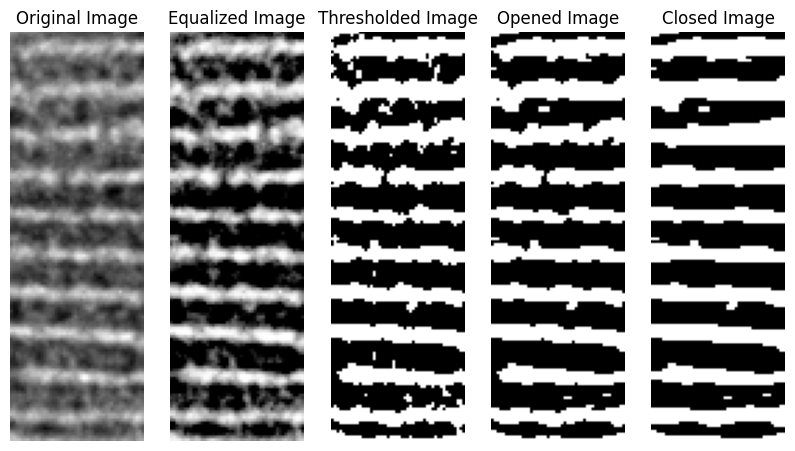

In [7]:
clip_low, clip_high = 75, 255

# choose an image
image = load_gray_image(images[6])
equalized = equalize_image(image, clip_low=clip_low, clip_high=clip_high)
thresholded = threshold_image(equalized)

# create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
kernel = numpy.ones((1, 3), numpy.uint8)

# remove small white spots in the image
opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)


# plot the raw image, the thresholded image, and the opened image
plt.figure(figsize=(10, 10))

plt.subplot(1, 5, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 5, 2)
plt.imshow(equalized, cmap="gray")
plt.axis("off")
plt.title("Equalized Image")

plt.subplot(1, 5, 3)
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Thresholded Image")

plt.subplot(1, 5, 4)
plt.imshow(opening, cmap="gray")
plt.axis("off")
plt.title("Opened Image")

plt.subplot(1, 5, 5)
plt.imshow(closing, cmap="gray")
plt.axis("off")
plt.title("Closed Image")







## now we need to create contours for the objects, and filter out the small ones


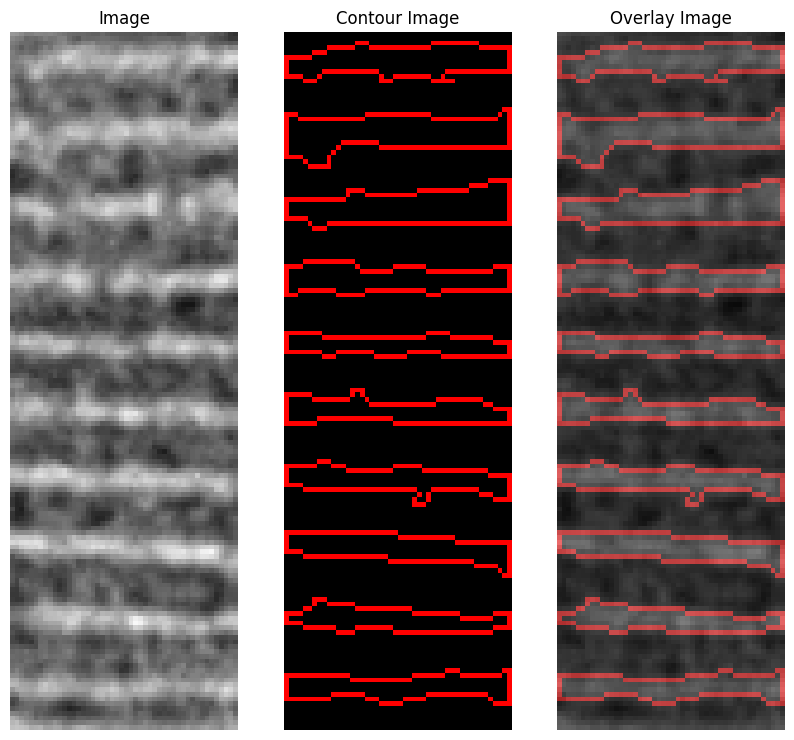

In [8]:
# find the contours in the image
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# filter by area
min_area = 100
max_area = 1e100
filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

# draw the contours on the image
contour_image = numpy.zeros_like(image)
cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), 1)

# create rgb copy of original image
rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# create a red contour image
contour_image = numpy.zeros_like(rgb_image)

cv2.drawContours(contour_image, filtered_contours, -1, (255, 0, 0), 1)

# create an image with the RGB image and the contour image overlaid
overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)

# plot the rgb_image, the contour image, and then the overlay
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(contour_image)
plt.axis("off")
plt.title("Contour Image")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis("off")
plt.title("Overlay Image")

plt.savefig("output/contours.png")

## Function to do all the things


In [9]:
def load_gray_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = numpy.clip(equalized, clip_low, clip_high)
    return equalized

def process_image_strip(image_path: str, metadata: dict) -> dict:
    # load the image
    image = load_gray_image(image_path)

    print(f"Processing {image_path}")
    # equalize the image
    equalized = equalize_image(image, metadata["clip_low"], metadata["clip_high"])


    # threshold the image
    if metadata["threshold_type"] == "otsu":
        _, thresholded = cv2.threshold(image, metadata["th_min_value"], metadata["th_max_value"], cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        thresholded = cv2.adaptiveThreshold(equalized, metadata["th_max_value"], cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, metadata["th_block_size"], metadata["th_constant"])
        
    # create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
    kernel = numpy.ones((metadata["k0"], metadata["k1"]), numpy.uint8)

    # remove small white spots in the image
    opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=metadata["opening_iterations"])
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=metadata["closing_iterations"])

    # find the contours in the image
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter by area
    filtered_contours = [c for c in contours if metadata["min_area"] < cv2.contourArea(c) <  metadata["max_area"]]

    return {"image": image, "equalized": equalized, "thresholded": thresholded, "closing": closing, "filtered_contours": filtered_contours, "raw_image": cv2.imread(image_path)}


data/new_strips/013 WT-DA-1 19k new sec strip 2.png
Processing data/new_strips/013 WT-DA-1 19k new sec strip 2.png
(106, 62)
(106, 62)
data/new_strips/013 WT-DA-1 19k new sec strip 4.png
Processing data/new_strips/013 WT-DA-1 19k new sec strip 4.png
(106, 33)
(106, 33)
data/new_strips/004 WT-DA 25k strip 2.png
Processing data/new_strips/004 WT-DA 25k strip 2.png
(101, 135)
(101, 135)
data/new_strips/004 WT-DA 25k strip 5.png
Processing data/new_strips/004 WT-DA 25k strip 5.png
(105, 153)
(105, 153)
data/new_strips/004 WT-DA 25k strip 3.png
Processing data/new_strips/004 WT-DA 25k strip 3.png
(126, 53)
(126, 53)
data/new_strips/013 WT-DA-1 19k new sec strip 3.png
Processing data/new_strips/013 WT-DA-1 19k new sec strip 3.png
(106, 48)
(106, 48)
data/new_strips/013 WT-DA-1 19k new sec strip 1.png
Processing data/new_strips/013 WT-DA-1 19k new sec strip 1.png
(147, 48)
(147, 48)
data/new_strips/004 WT-DA 25k strip 4.png
Processing data/new_strips/004 WT-DA 25k strip 4.png
(125, 123)
(125,

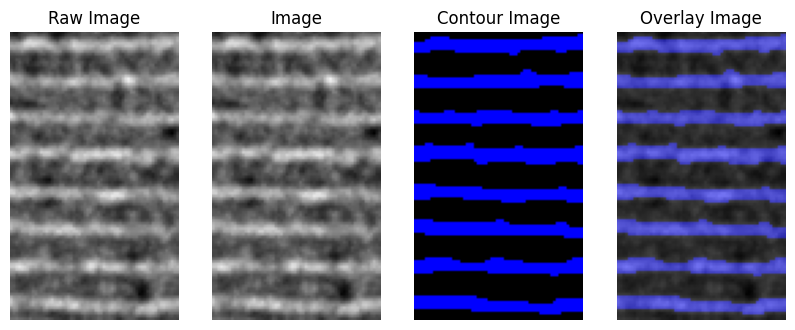

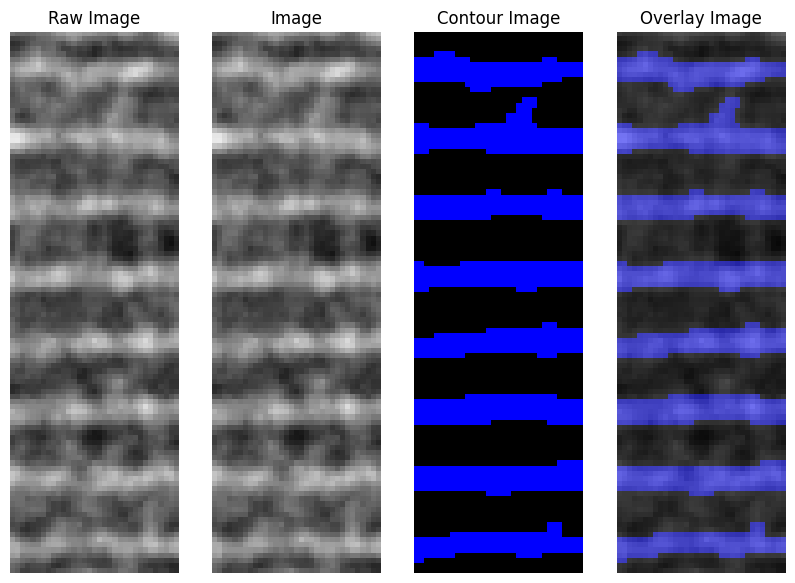

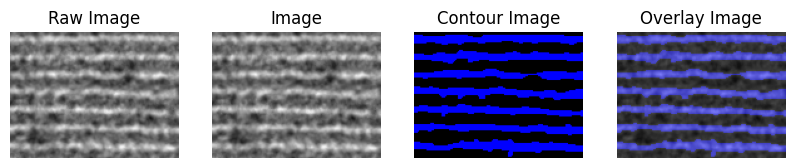

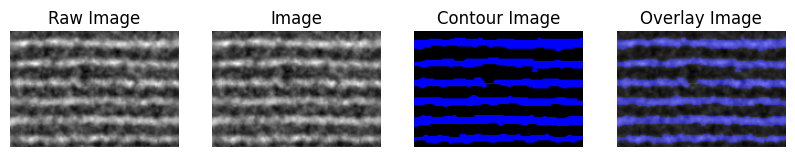

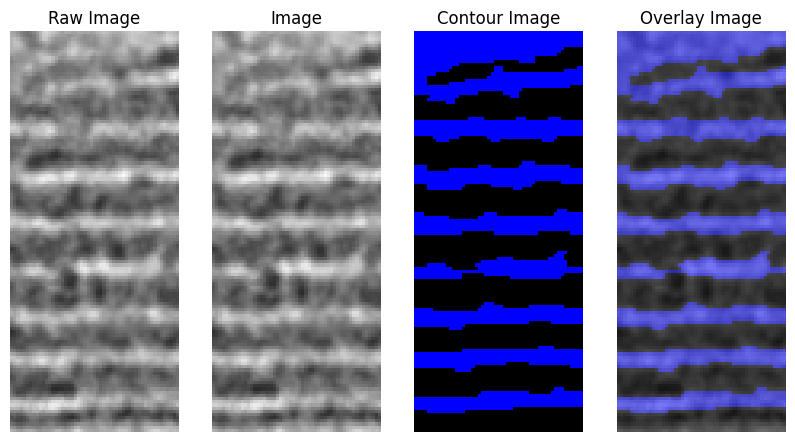

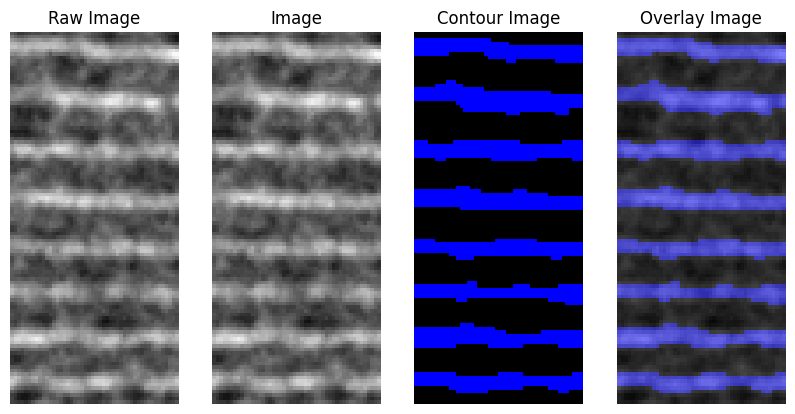

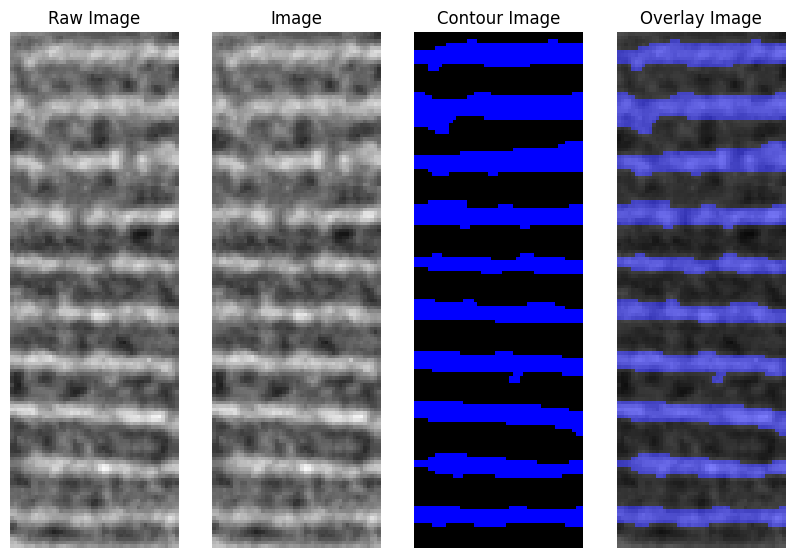

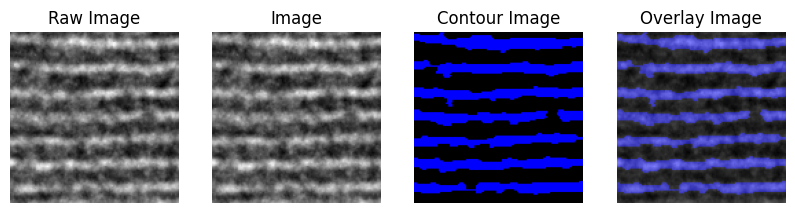

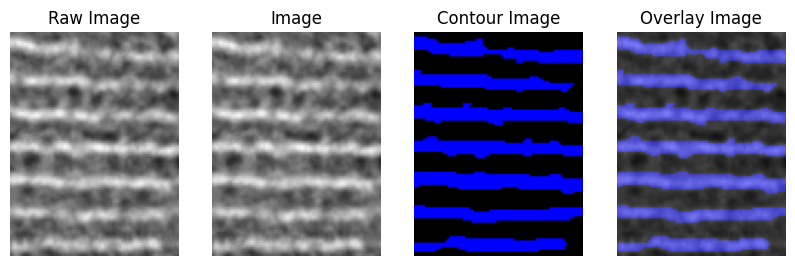

In [10]:
trial_number = 0
base_filepath =  f"output/trial_{trial_number}"
equalized_filepath = f"{base_filepath}/equalized"
contours_filepath =  f"{base_filepath}/contours"
comparison_filepath =  f"{base_filepath}/comparison"
overlay_filepath =  f"{base_filepath}/overlay"
thresholded_filepath =  f"{base_filepath}/thresholded"
strips_filepath = f"data/new_strips"
output_strips_filepath = f"{base_filepath}/strips"

images = glob.glob(f"{strips_filepath}/*.png")

contour_thickness = -1 # -1 to have the contour filled

# ensure that the directories exist
os.makedirs(contours_filepath, exist_ok=True)
os.makedirs(comparison_filepath, exist_ok=True)
os.makedirs(overlay_filepath, exist_ok=True)
os.makedirs(thresholded_filepath, exist_ok=True)
os.makedirs(output_strips_filepath, exist_ok=True)
os.makedirs(equalized_filepath, exist_ok=True)

# - image name
# - equalize histogram parameters, clip_low, clip_high
# - Otsu thresholding parameters
# - contour min and max area used for thresholding
# # - opening and closing kernel size and iterations
files_str = ", ".join(images)
meta_df = {"images": files_str,
           "clip_low": 100, 
           "clip_high": 255, 
           "min_area": 100, 
           "max_area": 1e100, 
           "k0": 1, # kernel dimensions y
           "k1": 3, # kernel dimensions x
           "opening_iterations": 1, 
           "closing_iterations": 3, 
           "threshold_type": "otsu",
           "th_min_value": 0,
            "th_max_value": 255,
           "th_block_size": 15,
           "th_constant": 2,}

# write out the metadata as a json file
import json
with open(f"{base_filepath}/metadata.json", "w") as f:
    f.write(json.dumps(meta_df, indent=4))


for filename in images:
    print(filename)

    # save to output strips
    cv2.imwrite(f"{output_strips_filepath}/{os.path.basename(filename)}", cv2.imread(filename))
    
    processed = process_image_strip(filename, meta_df)
    
    print(processed["closing"].shape)
    print(processed["image"].shape)
    
    image_name = os.path.basename(filename)
    cv2.imwrite(f"{thresholded_filepath}/{image_name}", processed["thresholded"])

    image = processed["image"]
    cv2.imwrite(f"{equalized_filepath}/{image_name}", image)

    filtered_contours = processed["filtered_contours"]
    raw_image = processed["raw_image"]    
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # draw the contours on the image
    contour_image = numpy.zeros_like(image)
    cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), contour_thickness)

    # save the contour image
    cv2.imwrite(f"{contours_filepath}/{image_name}", contour_image)

    # create rgb copy of original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # # create a red contour image
    contour_image = numpy.zeros_like(rgb_image)

    cv2.drawContours(contour_image, filtered_contours, -1, (0, 0, 255), contour_thickness)

    # create an image with the RGB image and the contour image overlaid
    overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)
    
    cv2.imwrite(f"{overlay_filepath}/{image_name}", overlay)
    
    # plot the rgb_image, the contour image, and then the overlay
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(raw_image)
    plt.axis("off")
    plt.title("Raw Image")
    
    plt.subplot(1, 4, 2)
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 4, 3)
    plt.imshow(contour_image)
    plt.axis("off")
    plt.title("Contour Image")

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay Image")

    plt.savefig(f"{comparison_filepath}/{image_name}")
    
